In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [129]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [25]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""

full_df = bq.Client().query(query).to_dataframe()
ml_df = full_df.sample(frac=0.1)
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
1232312,282665314,7.65,1034.167408,186.235111,62.571525,NaN,None,NL,None,1993.0,43,0.612123,32.840809,1043.0,South Holland
1598212,470741095,8.62,1268.696191,147.046589,53.326773,NaN,None,NL,None,2016.0,9,0.858675,24.638573,152.0,South Holland
609690,268734970,9.22,54.772782,30.149440,10.884133,NaN,None,NL,None,1968.0,5,0.870178,11.082508,623.0,South Holland
797856,290334929,9.48,65.392662,41.342501,16.128151,NaN,None,NL,None,1975.0,7,0.693382,14.538329,315.0,South Holland
708188,253611189,4.66,32.817785,27.912468,11.348454,NaN,None,NL,None,1971.0,8,0.727547,11.661943,154.0,South Holland


In [49]:
cat_df = full_df[cat_cols]
num_df = full_df[num_cols]


In [50]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,1.638666e+06,1.638666e+06,1.638666e+06,23102.000000,1.638534e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638432e+06
mean,1.284413e+02,3.442989e+01,1.248890e+01,1.534716,1.970038e+03,7.308884e+00,8.203220e-01,1.150416e+01,6.271445e+02
std,1.201438e+03,4.307075e+01,1.500313e+01,1.667968,3.692588e+01,5.192885e+00,7.008799e-02,5.160273e+00,3.077715e+02
min,2.650812e-04,8.183244e-02,3.404680e-02,-4.000000,1.131000e+03,4.000000e+00,2.828082e-02,6.413288e-01,1.000000e+00
25%,1.107290e+01,1.383930e+01,5.054998e+00,1.000000,1.957000e+03,5.000000e+00,7.915906e-01,7.573893e+00,4.300000e+02
50%,5.009999e+01,2.977105e+01,1.085595e+01,1.000000,1.976000e+03,5.000000e+00,8.439439e-01,1.113455e+01,6.390000e+02
75%,7.143773e+01,3.887442e+01,1.431944e+01,2.000000,1.993000e+03,8.000000e+00,8.719881e-01,1.333404e+01,8.330000e+02
max,2.562055e+05,3.925806e+03,9.652139e+02,44.000000,2.020000e+03,7.930000e+02,9.999417e-01,2.340868e+02,2.143000e+03


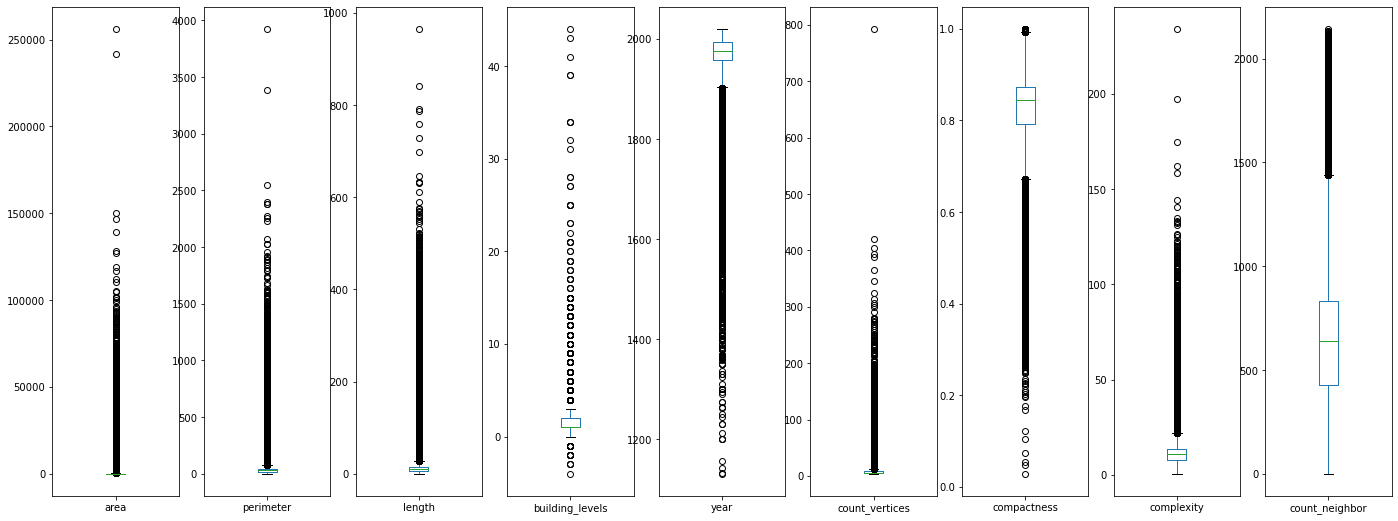

In [51]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('exploratory_full/south_holland_basic_distribution_null.png')

In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [129]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [25]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""

full_df = bq.Client().query(query).to_dataframe()
ml_df = full_df.sample(frac=0.1)
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
1232312,282665314,7.65,1034.167408,186.235111,62.571525,NaN,None,NL,None,1993.0,43,0.612123,32.840809,1043.0,South Holland
1598212,470741095,8.62,1268.696191,147.046589,53.326773,NaN,None,NL,None,2016.0,9,0.858675,24.638573,152.0,South Holland
609690,268734970,9.22,54.772782,30.149440,10.884133,NaN,None,NL,None,1968.0,5,0.870178,11.082508,623.0,South Holland
797856,290334929,9.48,65.392662,41.342501,16.128151,NaN,None,NL,None,1975.0,7,0.693382,14.538329,315.0,South Holland
708188,253611189,4.66,32.817785,27.912468,11.348454,NaN,None,NL,None,1971.0,8,0.727547,11.661943,154.0,South Holland


In [27]:
print(ml_df.shape)

(163867, 15)


In [29]:
print(ml_df.dtypes)

osm_way_id          object
bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object


In [30]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [31]:
print('count unique city:', len(pd.unique(ml_df['city'])))
print('unique city:', pd.unique(ml_df['city']))

print('\ncount unique postcode:', len(pd.unique(ml_df['postcode'])))
print('unique postcode:', pd.unique(ml_df['postcode']))

print('\ncount unique year:', len(pd.unique(ml_df['year'])))
print('unique year:', pd.unique(ml_df['year']))

count unique city: 38
unique city: [NaN, 's-Gravenhage, Zoetermeer, Voorburg, Rotterdam, ..., Sassenheim, Kinderdijk, Honselersdijk, Papendrecht, Hendrik-Ido-Ambacht]
Length: 38
Categories (37, object): ['s-Gravenhage, Zoetermeer, Voorburg, Rotterdam, ..., Kinderdijk, Honselersdijk, Papendrecht, Hendrik-Ido-Ambacht]

count unique postcode: 81
unique postcode: [NaN, 2571PV, 2718CX, 2518GX, 2611CG, ..., 2245AB, 3131HA, 2552EN, 2631PA, 3341VC]
Length: 81
Categories (80, object): [2571PV, 2718CX, 2518GX, 2611CG, ..., 3131HA, 2552EN, 2631PA, 3341VC]

count unique year: 380
unique year: [1993. 2016. 1968. 1975. 1971. 1990. 1988. 1934. 1973. 1950. 1981. 1910.
 1978. 1980. 2017. 1961. 1994. 1999. 1949. 1927. 1986. 2013. 1995. 1997.
 1977. 1958. 1979. 1935. 2003. 2005. 1940. 1750. 1976. 1930. 1965. 1991.
 1956. 2019. 1966. 2002. 1923. 1960. 1928. 2010. 1972. 1943. 1984. 2008.
 2009. 1989. 1941. 1970. 2018. 1998. 1992. 1897. 1962. 1957. 2000. 1903.
 1955. 1967. 1987. 2007. 1963. 1982. 2001. 2015

In [32]:
ml_df.isna().sum()


bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161554
city               163781
country                 0
postcode           163782
year                   15
count_vertices          0
compactness             0
complexity              0
count_neighbor         25
state_name              0
dtype: int64

In [33]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
# drop country as it is irrelevant in this model
ml_df = ml_df.drop(['country', 'state_name'], axis=1)
# drop count_neighbor for now as it is irrelevant in this model
# ml_df = ml_df.drop('count_neighbor', axis=1)

In [46]:
cat_df_10prct = ml_df[cat_cols]
num_df_10prct = ml_df[num_cols]


In [47]:
num_df_10prct.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2313.000000,163852.000000,163867.000000,163867.000000,163867.000000,163842.000000
mean,128.019831,34.218164,12.420241,1.553394,1970.038645,7.304619,0.820669,11.469473,627.781137
std,1186.409746,42.726507,15.009008,1.768092,36.983610,5.236873,0.069769,5.116812,307.718882
min,0.141041,3.282065,1.181298,-1.000000,1156.000000,4.000000,0.177021,3.651454,1.000000
25%,10.990359,13.790559,5.038831,1.000000,1957.000000,5.000000,0.792292,7.561842,430.000000
50%,49.974406,29.722637,10.841567,1.000000,1976.000000,5.000000,0.844006,11.124068,640.000000
75%,71.076536,38.721033,14.275359,1.000000,1993.000000,8.000000,0.872043,13.309009,835.000000
max,101870.148481,2379.435915,569.028489,32.000000,2020.000000,366.000000,0.999942,140.535339,2130.000000


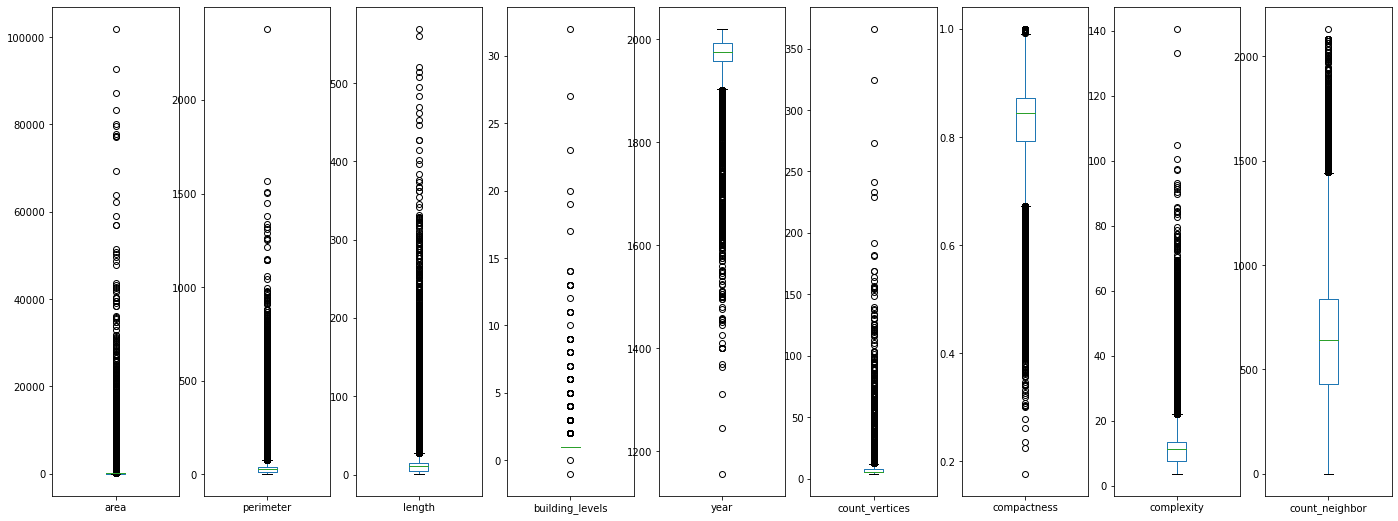

In [48]:

num_df_10prct.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('model_cv_multicollinearity_10prct/run0/exploratory/south_holland_basic_distribution_null.png')

In [37]:
X = ml_df.drop('bldg_height', axis=1)
y = ml_df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [38]:
X.shape

(163867, 11)

In [39]:
y.shape

(163867,)

In [40]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('normalizer', Normalizer())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('normalizer', Normalizer())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('normalizer', Normalizer())])

In [41]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [42]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [19]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [39]:
print(sorted(sklearn.metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [43]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))


In [65]:
mae_reg_scores = {}

In [73]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -3.122177 (std: 0.002971, max: -3.117985, min: -3.127164) took 0.583108 seconds
DT: avg: -3.122294 (std: 0.003501, max: -3.118538, min: -3.128716) took 0.619183 seconds
KNN: avg: -3.281548 (std: 0.223241, max: -3.105337, min: -3.656609) took 0.580567 seconds
RF: avg: -3.121660 (std: 0.002907, max: -3.118218, min: -3.126913) took 0.584553 seconds
AB: avg: -3.118173 (std: 0.004327, max: -3.113264, min: -3.124869) took 0.601068 seconds
B: avg: -3.121923 (std: 0.002858, max: -3.118438, min: -3.126988) took 0.608253 seconds
GB: avg: -3.121648 (std: 0.002924, max: -3.117884, min: -3.126798) took 0.618406 seconds


In [103]:
mae_reg_scores

{'LR': array([-3.1271638 , -3.12201071, -3.11798487, -3.12272322, -3.12100364]),
 'DT': array([-3.12871556, -3.1215762 , -3.11853773, -3.1226472 , -3.11999578]),
 'RF': array([-3.12691337, -3.12123238, -3.11821759, -3.12188063, -3.12005685]),
 'AB': array([-3.12486903, -3.11697878, -3.11326381, -3.12127242, -3.11448194]),
 'B': array([-3.12698816, -3.12162678, -3.11843788, -3.12231569, -3.12024783]),
 'GB': array([-3.12679802, -3.12105487, -3.11788384, -3.12209045, -3.12041422]),
 'KNN': array([-3.65660918, -3.11779824, -3.10533659, -3.4221624 , -3.10583493])}

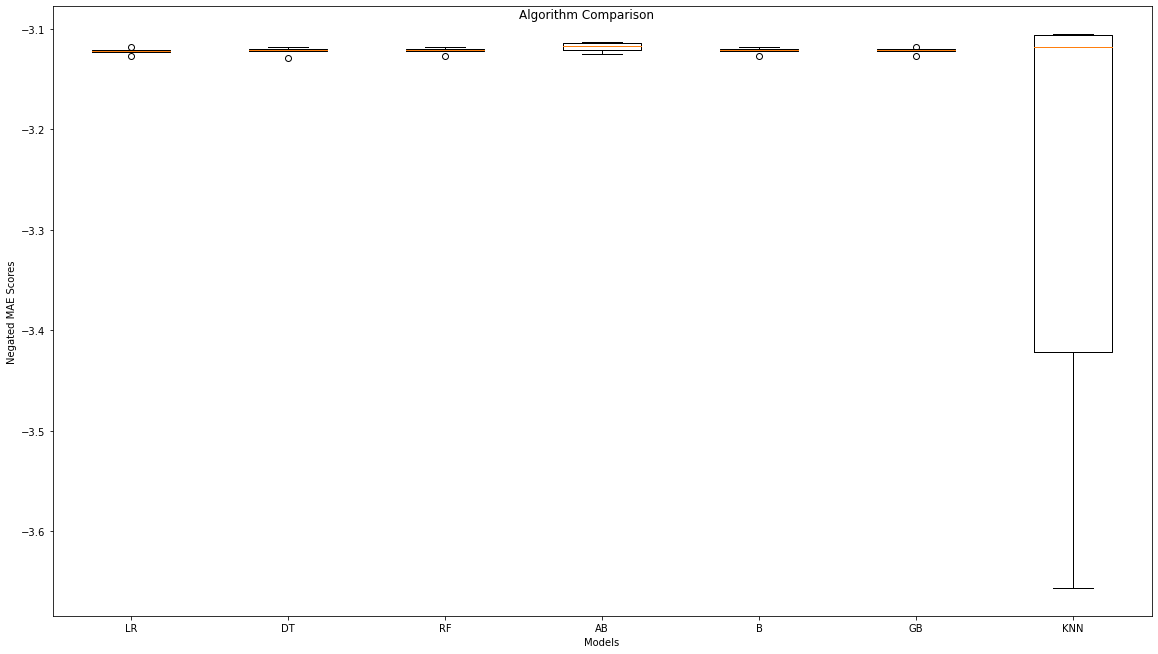

In [76]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_MAE.png', dpi=600)

In [102]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

{'LR': array([3.1271638 , 3.12201071, 3.11798487, 3.12272322, 3.12100364]),
 'DT': array([3.12871556, 3.1215762 , 3.11853773, 3.1226472 , 3.11999578]),
 'RF': array([3.12691337, 3.12123238, 3.11821759, 3.12188063, 3.12005685]),
 'AB': array([3.12486903, 3.11697878, 3.11326381, 3.12127242, 3.11448194]),
 'B': array([3.12698816, 3.12162678, 3.11843788, 3.12231569, 3.12024783]),
 'GB': array([3.12679802, 3.12105487, 3.11788384, 3.12209045, 3.12041422]),
 'KNN': array([3.65660918, 3.11779824, 3.10533659, 3.4221624 , 3.10583493])}

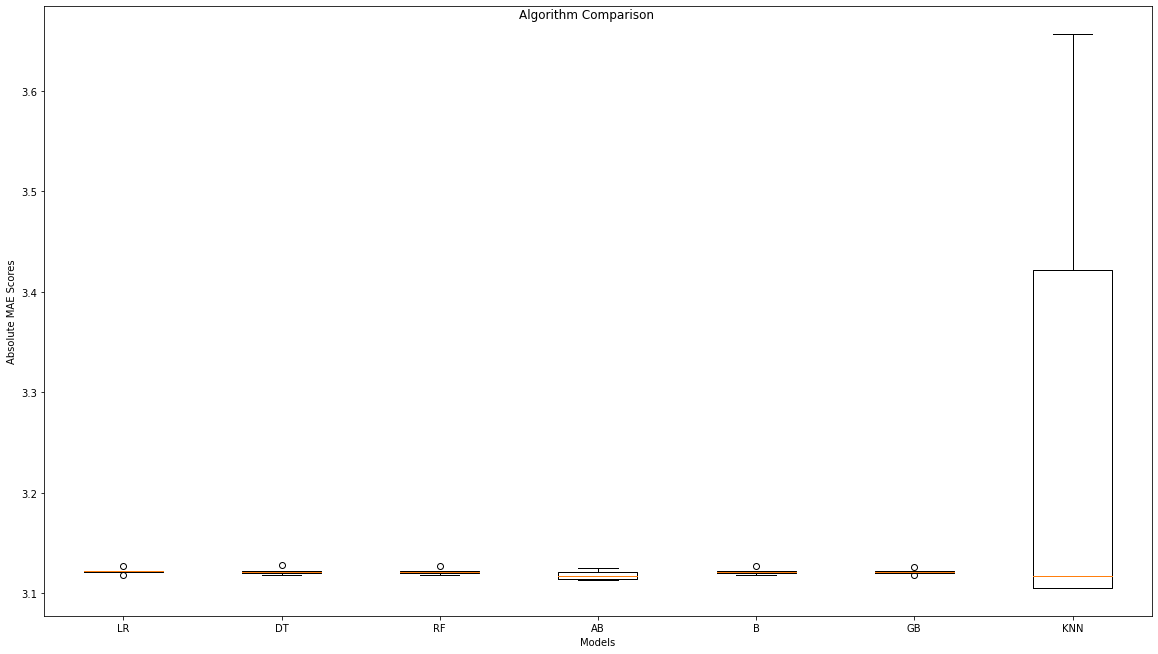

In [104]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_ABS-MAE.png', dpi=600)

In [106]:

if 'KNN' in mae_reg_scores.keys():
    del mae_reg_scores['KNN'] 
mae_reg_scores

{'LR': array([-3.1271638 , -3.12201071, -3.11798487, -3.12272322, -3.12100364]),
 'DT': array([-3.12871556, -3.1215762 , -3.11853773, -3.1226472 , -3.11999578]),
 'RF': array([-3.12691337, -3.12123238, -3.11821759, -3.12188063, -3.12005685]),
 'AB': array([-3.12486903, -3.11697878, -3.11326381, -3.12127242, -3.11448194]),
 'B': array([-3.12698816, -3.12162678, -3.11843788, -3.12231569, -3.12024783]),
 'GB': array([-3.12679802, -3.12105487, -3.11788384, -3.12209045, -3.12041422])}

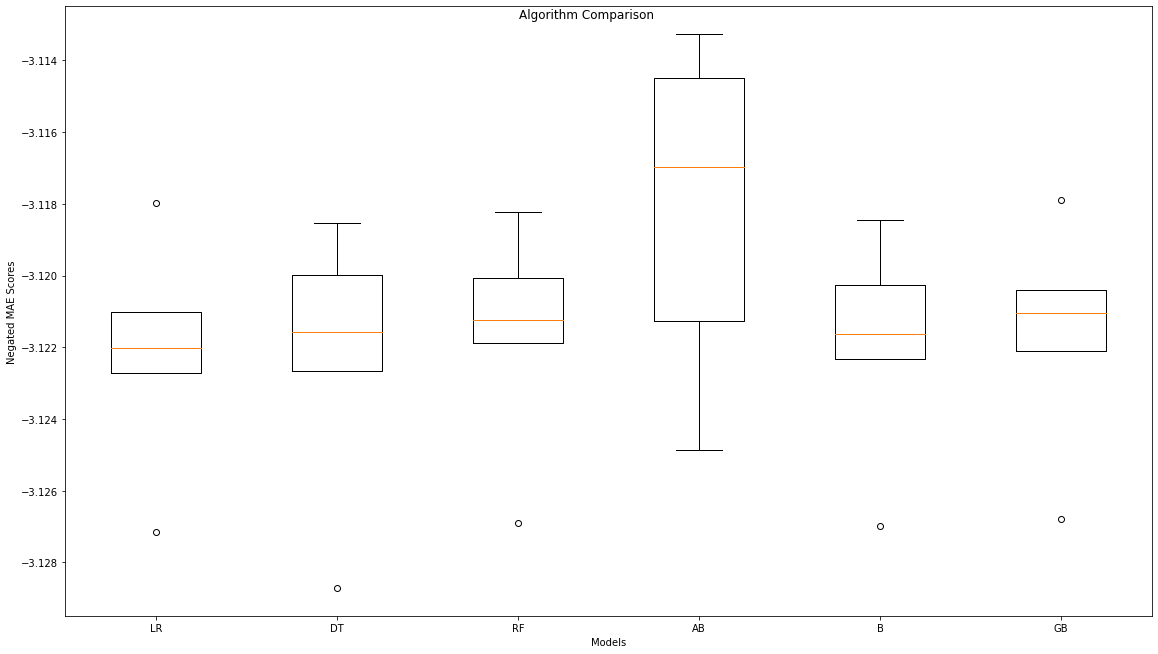

In [107]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_MAE_Except-KNN.png', dpi=600)


In [105]:
if 'KNN' in abs_mae_reg_scores.keys():
    del abs_mae_reg_scores['KNN'] 
abs_mae_reg_scores

{'LR': array([3.1271638 , 3.12201071, 3.11798487, 3.12272322, 3.12100364]),
 'DT': array([3.12871556, 3.1215762 , 3.11853773, 3.1226472 , 3.11999578]),
 'RF': array([3.12691337, 3.12123238, 3.11821759, 3.12188063, 3.12005685]),
 'AB': array([3.12486903, 3.11697878, 3.11326381, 3.12127242, 3.11448194]),
 'B': array([3.12698816, 3.12162678, 3.11843788, 3.12231569, 3.12024783]),
 'GB': array([3.12679802, 3.12105487, 3.11788384, 3.12209045, 3.12041422])}

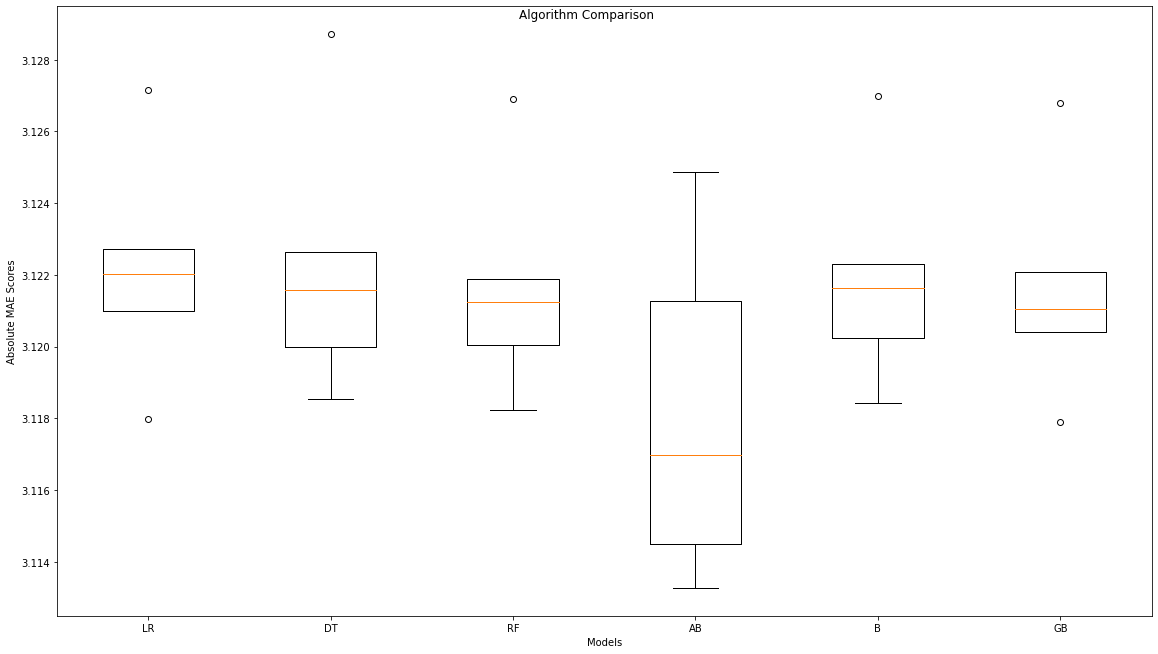

In [109]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_ABS-MAE_Except-KNN.png', dpi=600)

In [110]:
mse_reg_scores = {}

In [111]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -14.257174 (std: 0.116667, max: -14.084465, min: -14.426079) took 1.375414 seconds
DT: avg: -14.266771 (std: 0.114532, max: -14.078789, min: -14.425465) took 0.572624 seconds
KNN: avg: -17.389747 (std: 3.809626, max: -14.239313, min: -23.344212) took 0.601124 seconds
RF: avg: -14.255489 (std: 0.119385, max: -14.079912, min: -14.426206) took 0.565534 seconds
AB: avg: -14.312931 (std: 0.124268, max: -14.111028, min: -14.482147) took 0.559760 seconds
B: avg: -14.254560 (std: 0.115528, max: -14.081160, min: -14.412298) took 0.583990 seconds
GB: avg: -14.252340 (std: 0.118092, max: -14.079441, min: -14.423220) took 0.598116 seconds


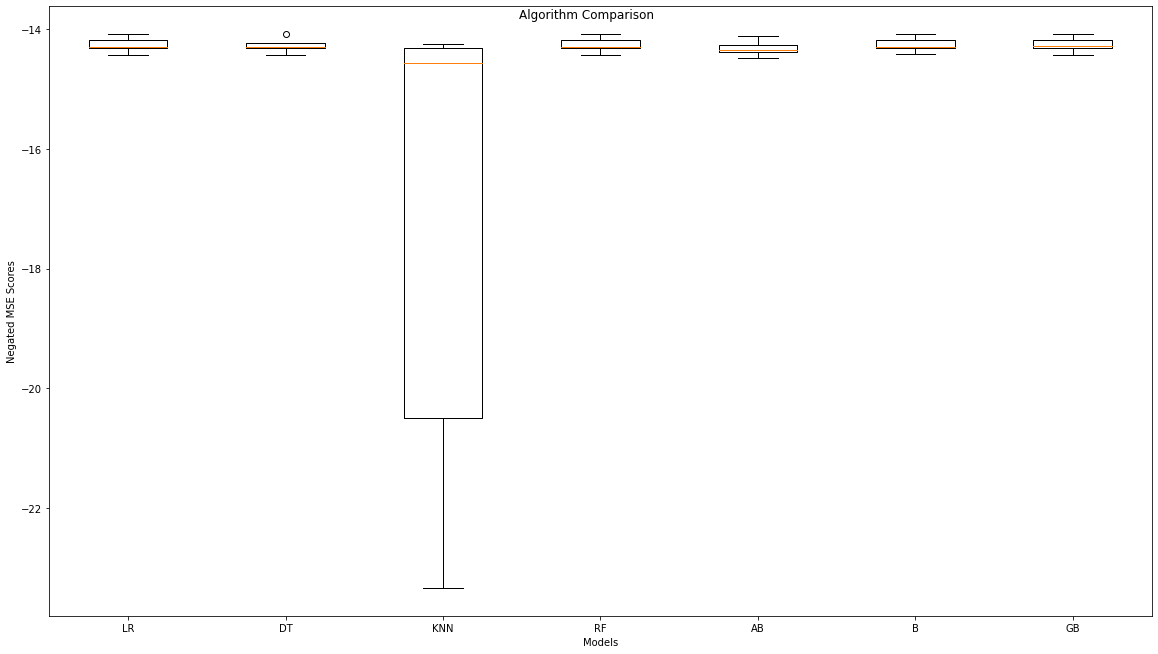

In [112]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_MSE.png', dpi=600)
plt.show()

In [113]:
abs_mse_reg_scores = {}
for k, v in mse_reg_scores.items():
    abs_mse_reg_scores[k] = np.absolute(v)
    
abs_mse_reg_scores

{'LR': array([14.17832574, 14.29276419, 14.30423683, 14.42607906, 14.08446485]),
 'DT': array([14.22265811, 14.28885465, 14.31808711, 14.42546454, 14.07878877]),
 'KNN': array([23.34421204, 14.30663723, 14.55936668, 20.49920758, 14.23931285]),
 'RF': array([14.17145304, 14.28812527, 14.31174837, 14.42620555, 14.07991162]),
 'AB': array([14.25499953, 14.34497092, 14.37150789, 14.48214749, 14.11102827]),
 'B': array([14.17177416, 14.29724522, 14.31032302, 14.41229751, 14.08115959]),
 'GB': array([14.16955213, 14.28512962, 14.30435797, 14.42321982, 14.07944127])}

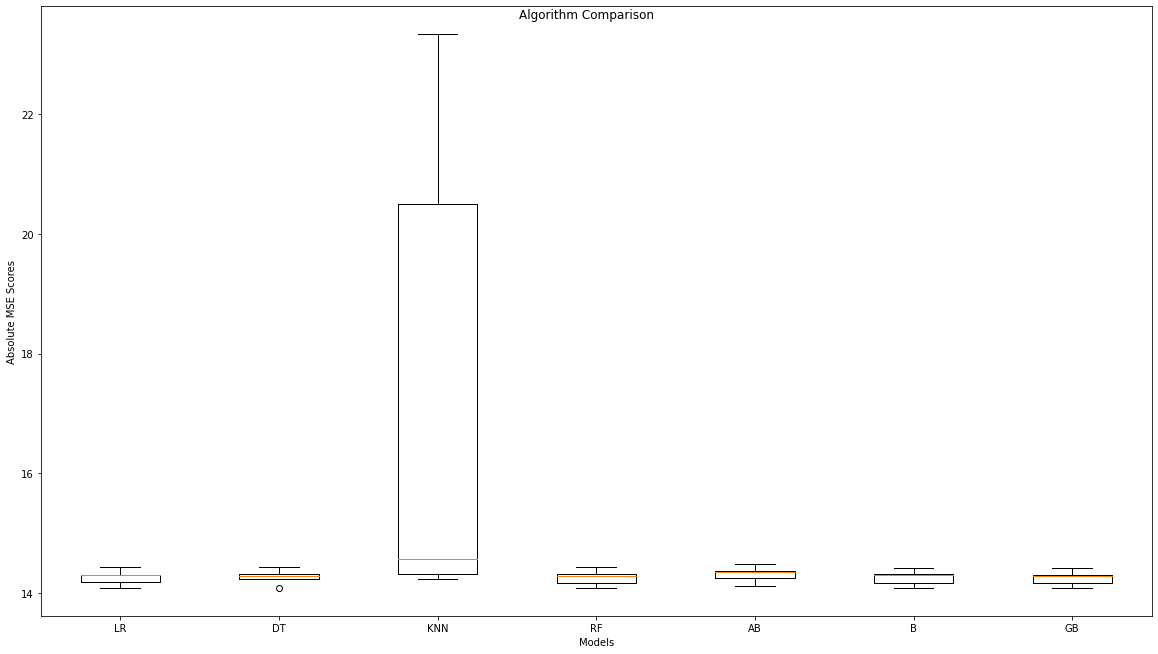

In [114]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_ABS-MSE.png', dpi=600)

In [115]:
if 'KNN' in mse_reg_scores.keys():
    del mse_reg_scores['KNN'] 
mse_reg_scores

{'LR': array([-14.17832574, -14.29276419, -14.30423683, -14.42607906,
        -14.08446485]),
 'DT': array([-14.22265811, -14.28885465, -14.31808711, -14.42546454,
        -14.07878877]),
 'RF': array([-14.17145304, -14.28812527, -14.31174837, -14.42620555,
        -14.07991162]),
 'AB': array([-14.25499953, -14.34497092, -14.37150789, -14.48214749,
        -14.11102827]),
 'B': array([-14.17177416, -14.29724522, -14.31032302, -14.41229751,
        -14.08115959]),
 'GB': array([-14.16955213, -14.28512962, -14.30435797, -14.42321982,
        -14.07944127])}

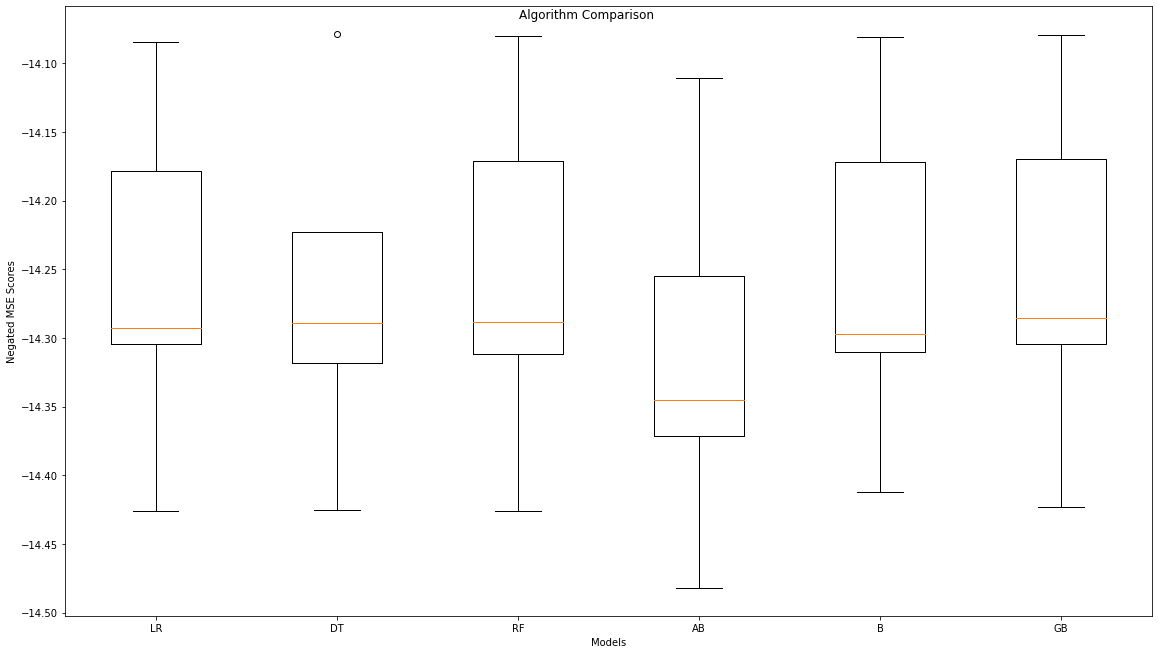

In [116]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_MSE_Except-KNN.png', dpi=600)
plt.show()

In [117]:
if 'KNN' in abs_mse_reg_scores.keys():
    del abs_mse_reg_scores['KNN'] 
abs_mse_reg_scores

{'LR': array([14.17832574, 14.29276419, 14.30423683, 14.42607906, 14.08446485]),
 'DT': array([14.22265811, 14.28885465, 14.31808711, 14.42546454, 14.07878877]),
 'RF': array([14.17145304, 14.28812527, 14.31174837, 14.42620555, 14.07991162]),
 'AB': array([14.25499953, 14.34497092, 14.37150789, 14.48214749, 14.11102827]),
 'B': array([14.17177416, 14.29724522, 14.31032302, 14.41229751, 14.08115959]),
 'GB': array([14.16955213, 14.28512962, 14.30435797, 14.42321982, 14.07944127])}

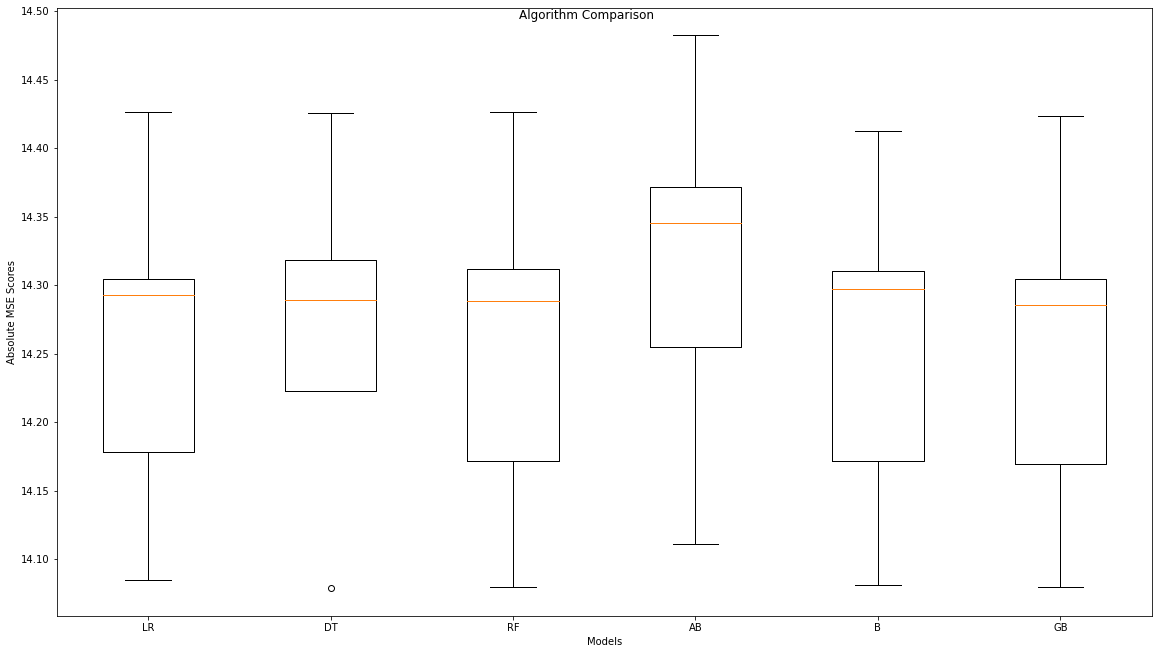

In [118]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_ABS-MSE_Except-KNN.png', dpi=600)
plt.show()

In [119]:
r2_reg_scores = {}

In [125]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: 0.000097 (std: 0.000826, max: 0.001200, min: -0.000855) took 0.589856 seconds
DT: avg: -0.001066 (std: 0.002145, max: 0.000315, min: -0.005319) took 0.617447 seconds
KNN: avg: -0.219361 (std: 0.266593, max: -0.001658, min: -0.647880) took 0.604132 seconds
RF: avg: 0.000098 (std: 0.000458, max: 0.000802, min: -0.000452) took 0.580358 seconds
AB: avg: -0.005929 (std: 0.003303, max: -0.002353, min: -0.010784) took 0.601826 seconds
B: avg: 0.000189 (std: 0.000653, max: 0.001469, min: -0.000304) took 0.613368 seconds
GB: avg: 0.000390 (std: 0.000676, max: 0.001403, min: -0.000459) took 0.595978 seconds


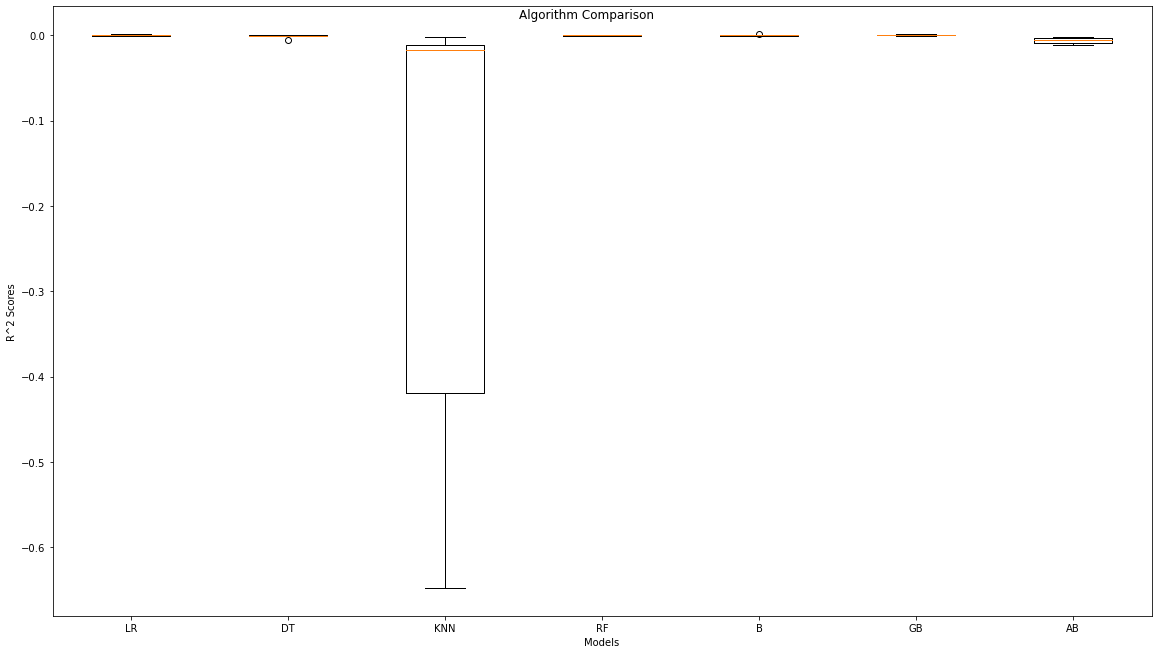

In [126]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_R2.png', dpi=600)
plt.show()

In [127]:
if 'KNN' in r2_reg_scores.keys():
    del r2_reg_scores['KNN']
r2_reg_scores

{'LR': array([-8.55138574e-04, -6.86737969e-04,  8.98953287e-04,  1.19999094e-03,
        -7.16657402e-05]),
 'DT': array([-0.00531865, -0.00031391, -0.00031893,  0.00031466,  0.00030719]),
 'RF': array([-3.25873138e-04, -4.52474606e-04,  3.67273418e-04,  8.01851351e-04,
         9.99681538e-05]),
 'B': array([-1.87794512e-04, -3.03984935e-04,  9.49501838e-05,  1.46889863e-03,
        -1.26425374e-04]),
 'GB': array([-0.00045869, -0.00014909,  0.00087365,  0.00140333,  0.00028056]),
 'AB': array([-0.00869747, -0.00282838, -0.0023527 , -0.01078445, -0.00498393])}

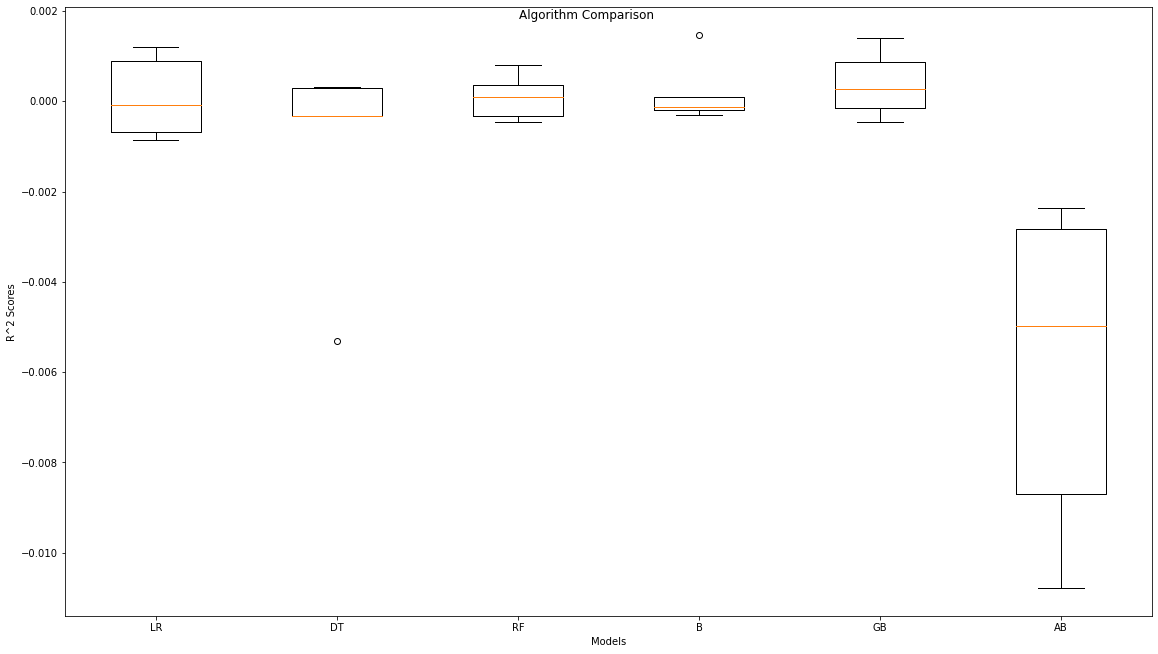

In [128]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/normalizer/South-Holland-10prct_R2_Except-KNN.png', dpi=600)
plt.show()

In [130]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

In [131]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [132]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [133]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
print(sorted(sklearn.metrics.SCORERS.keys()) )

In [134]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))


In [135]:
mae_reg_scores = {}

In [136]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -3.059978 (std: 0.006990, max: -3.052147, min: -3.069140) took 1.165939 seconds
DT: avg: -3.403867 (std: 0.010441, max: -3.394063, min: -3.422605) took 0.568973 seconds
KNN: avg: -2.996728 (std: 0.010126, max: -2.983957, min: -3.008701) took 0.564513 seconds
RF: avg: -3.082501 (std: 0.006989, max: -3.073464, min: -3.092517) took 0.620200 seconds
AB: avg: -3.617816 (std: 0.292926, max: -3.298612, min: -4.074427) took 1.106640 seconds
B: avg: -3.122090 (std: 0.008598, max: -3.111329, min: -3.135726) took 0.603239 seconds
GB: avg: -2.877799 (std: 0.004772, max: -2.869893, min: -2.882537) took 0.576103 seconds


In [137]:
mae_reg_scores

{'LR': array([-3.06696125, -3.05862735, -3.0530155 , -3.06913968, -3.0521468 ]),
 'DT': array([-3.40141185, -3.40657943, -3.42260451, -3.3940633 , -3.39467491]),
 'KNN': array([-3.00870071, -3.00487807, -2.98554232, -3.00056348, -2.98395744]),
 'RF': array([-3.08180811, -3.09251679, -3.08791317, -3.07680459, -3.07346438]),
 'AB': array([-3.84436783, -3.41253636, -4.07442727, -3.29861224, -3.45913832]),
 'B': array([-3.11132937, -3.13572597, -3.12642344, -3.12188857, -3.11508163]),
 'GB': array([-2.88253689, -2.88149571, -2.87478642, -2.88028149, -2.86989275])}

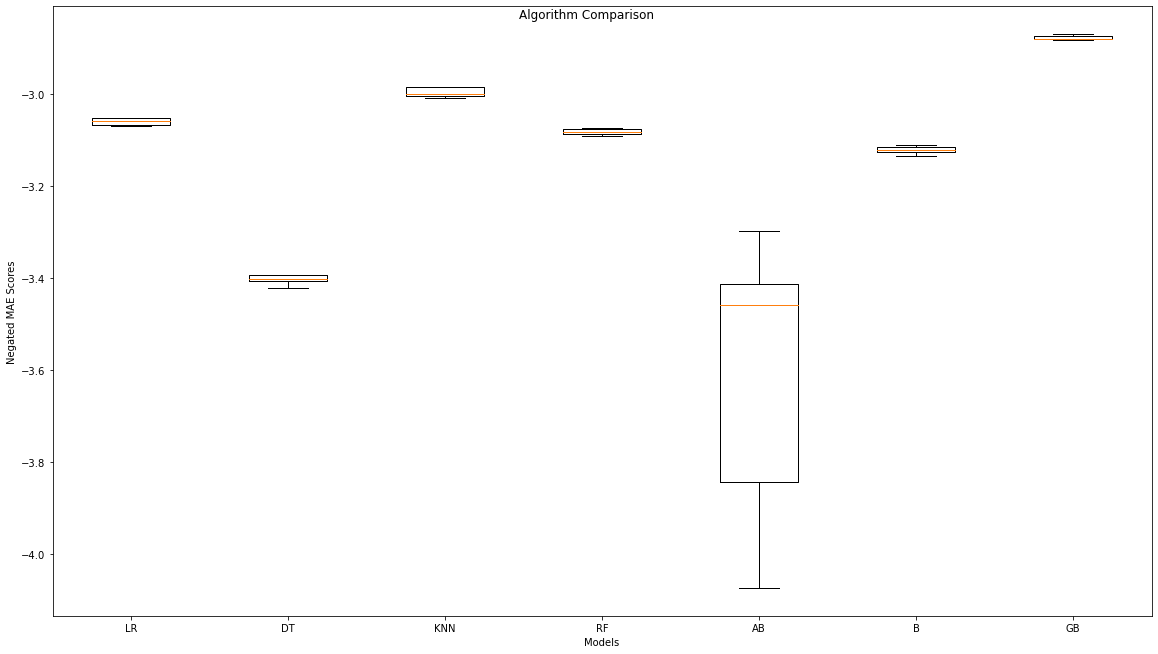

In [138]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_MAE.png', dpi=600)

7
7
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[-3.1271638  -3.12201071 -3.11798487 -3.12272322 -3.12100364]
[-3.12871556 -3.1215762  -3.11853773 -3.1226472  -3.11999578]
[-3.12691337 -3.12123238 -3.11821759 -3.12188063 -3.12005685]
[-3.12486903 -3.11697878 -3.11326381 -3.12127242 -3.11448194]
[-3.12698816 -3.12162678 -3.11843788 -3.12231569 -3.12024783]
[-3.12679802 -3.12105487 -3.11788384 -3.12209045 -3.12041422]
[-3.65660918 -3.11779824 -3.10533659 -3.4221624  -3.10583493]


In [139]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

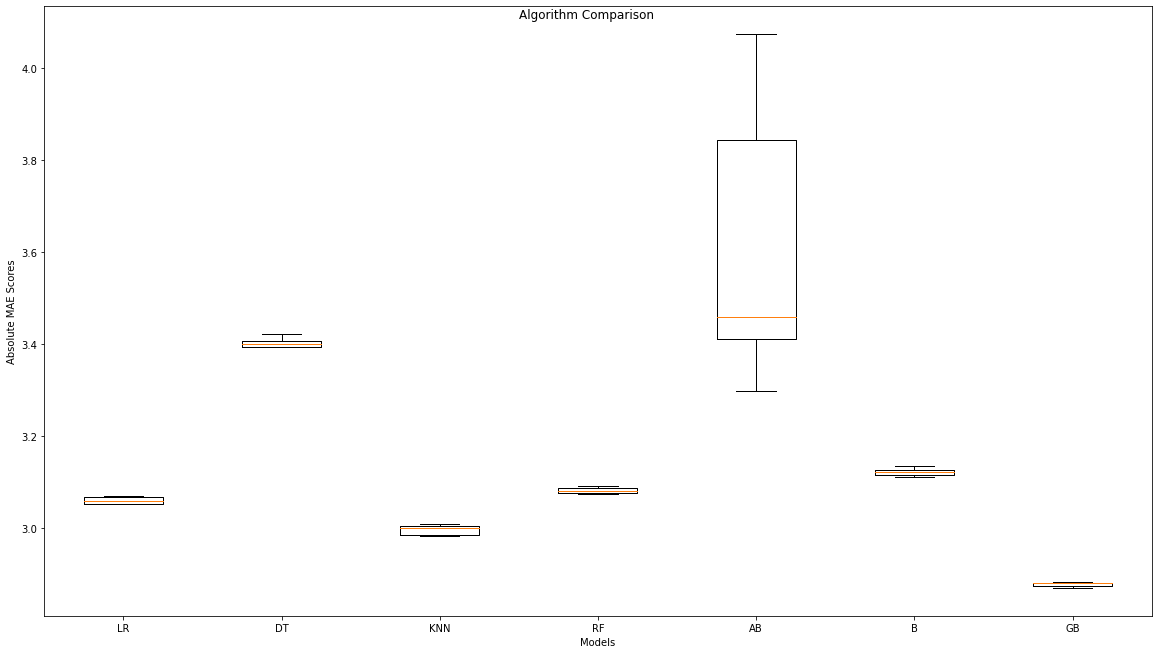

In [140]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_ABS-MAE.png', dpi=600)

In [141]:

if 'AB' in mae_reg_scores.keys():
    del mae_reg_scores['AB'] 
mae_reg_scores

{'LR': array([-3.06696125, -3.05862735, -3.0530155 , -3.06913968, -3.0521468 ]),
 'DT': array([-3.40141185, -3.40657943, -3.42260451, -3.3940633 , -3.39467491]),
 'KNN': array([-3.00870071, -3.00487807, -2.98554232, -3.00056348, -2.98395744]),
 'RF': array([-3.08180811, -3.09251679, -3.08791317, -3.07680459, -3.07346438]),
 'B': array([-3.11132937, -3.13572597, -3.12642344, -3.12188857, -3.11508163]),
 'GB': array([-2.88253689, -2.88149571, -2.87478642, -2.88028149, -2.86989275])}

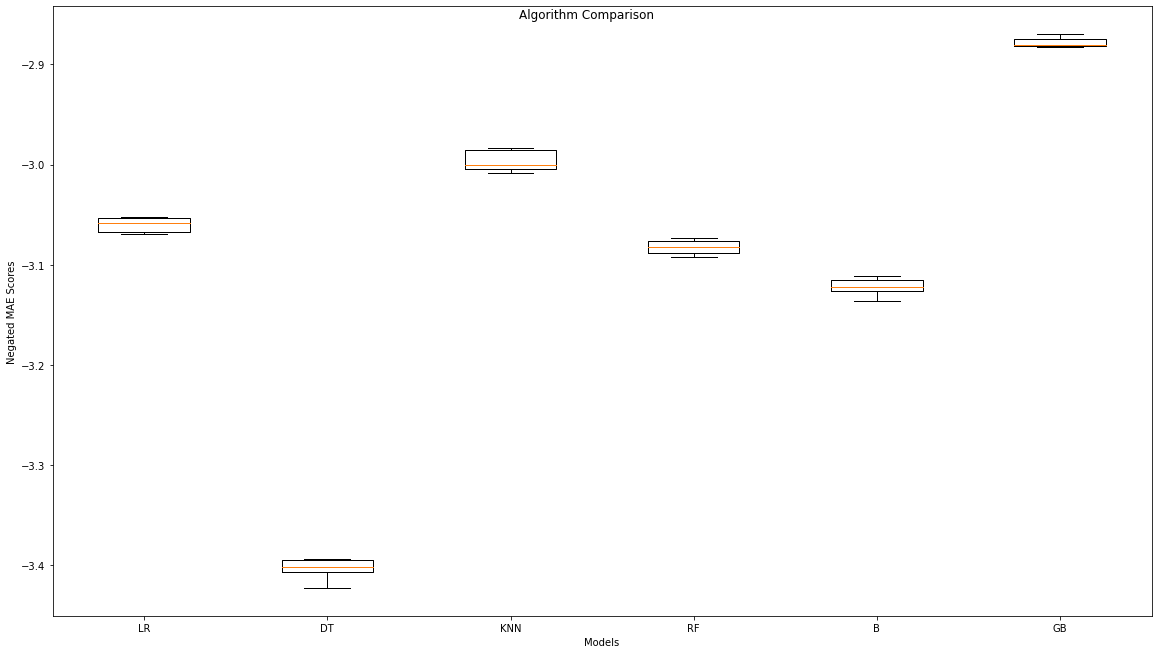

In [142]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_MAE_Except-AB.png', dpi=600)


In [143]:
if 'AB' in abs_mae_reg_scores.keys():
    del abs_mae_reg_scores['AB'] 
abs_mae_reg_scores

{'LR': array([3.06696125, 3.05862735, 3.0530155 , 3.06913968, 3.0521468 ]),
 'DT': array([3.40141185, 3.40657943, 3.42260451, 3.3940633 , 3.39467491]),
 'KNN': array([3.00870071, 3.00487807, 2.98554232, 3.00056348, 2.98395744]),
 'RF': array([3.08180811, 3.09251679, 3.08791317, 3.07680459, 3.07346438]),
 'B': array([3.11132937, 3.13572597, 3.12642344, 3.12188857, 3.11508163]),
 'GB': array([2.88253689, 2.88149571, 2.87478642, 2.88028149, 2.86989275])}

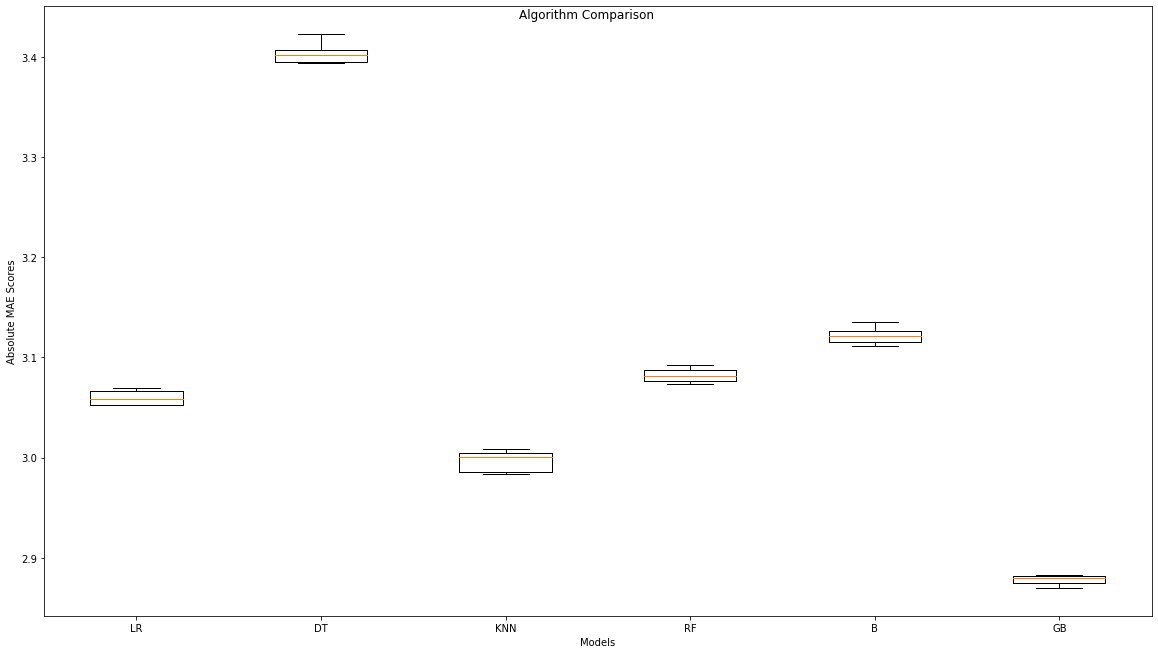

In [144]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_ABS-MAE_Except-AB.png', dpi=600)

In [145]:
mse_reg_scores = {}

In [146]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -13.276038 (std: 0.251452, max: -12.912285, min: -13.647378) took 1.372147 seconds
DT: avg: -21.518729 (std: 0.353220, max: -21.108573, min: -22.095799) took 0.579306 seconds
KNN: avg: -14.317389 (std: 0.258589, max: -13.969208, min: -14.626714) took 0.583049 seconds
RF: avg: -15.924081 (std: 0.305143, max: -15.466619, min: -16.375669) took 0.620309 seconds
AB: avg: -21.412509 (std: 7.991746, max: -12.935353, min: -36.497554) took 1.078523 seconds
B: avg: -16.536510 (std: 0.257589, max: -16.124873, min: -16.889284) took 0.566714 seconds
GB: avg: -12.133106 (std: 0.237151, max: -11.766079, min: -12.466728) took 0.558931 seconds


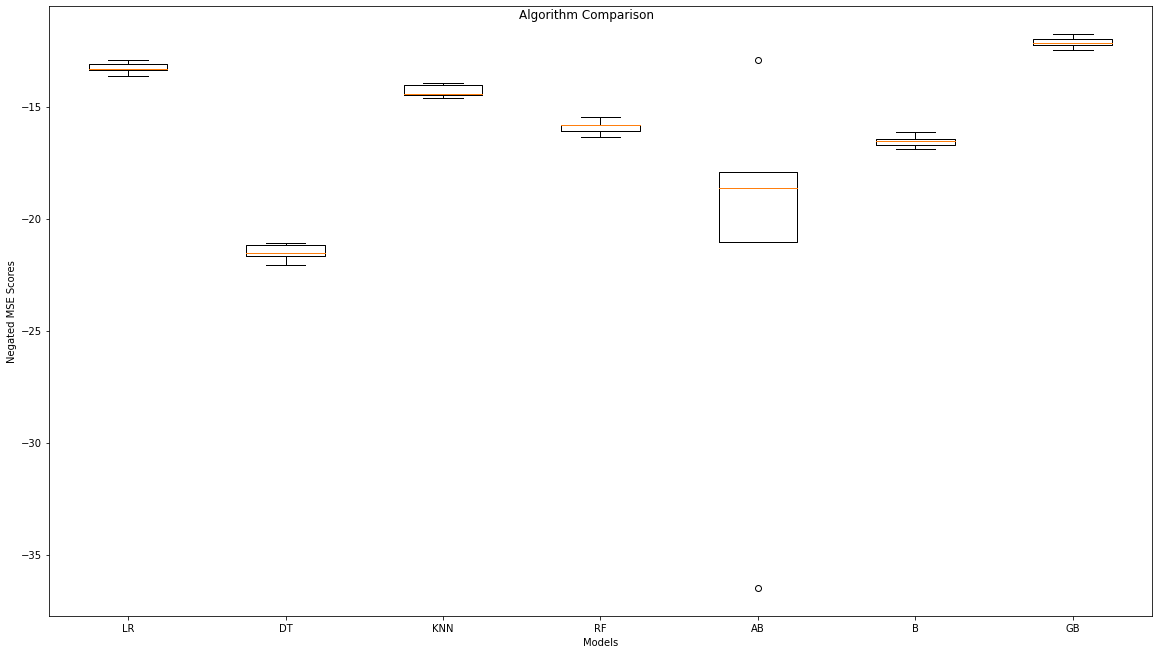

In [147]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_MSE.png', dpi=600)
plt.show()

In [148]:
abs_mse_reg_scores = {}
for k, v in mse_reg_scores.items():
    abs_mse_reg_scores[k] = np.absolute(v)
    
abs_mse_reg_scores

{'LR': array([13.34093733, 13.37960028, 13.09999017, 13.64737818, 12.91228524]),
 'DT': array([21.10857299, 21.52136634, 21.66655147, 22.09579899, 21.20135714]),
 'KNN': array([14.43557986, 14.50167767, 14.05376363, 14.62671421, 13.96920778]),
 'RF': array([15.82990007, 16.11282256, 15.83539262, 16.3756692 , 15.46661896]),
 'AB': array([21.05457012, 36.4975539 , 17.92680901, 18.64825929, 12.93535299]),
 'B': array([16.52021188, 16.70595537, 16.44222728, 16.88928428, 16.12487309]),
 'GB': array([12.16447602, 12.26489861, 12.00334732, 12.46672817, 11.76607881])}

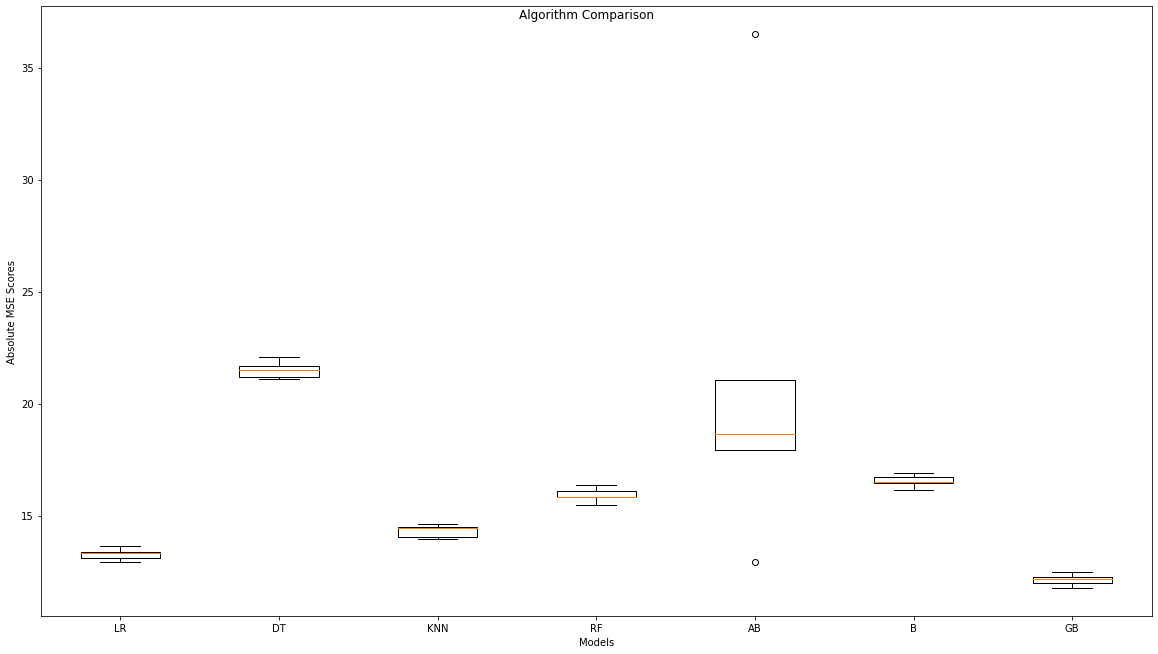

In [149]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_ABS-MSE.png', dpi=600)

In [150]:
if 'AB' in mse_reg_scores.keys():
    del mse_reg_scores['AB'] 
mse_reg_scores

{'LR': array([-13.34093733, -13.37960028, -13.09999017, -13.64737818,
        -12.91228524]),
 'DT': array([-21.10857299, -21.52136634, -21.66655147, -22.09579899,
        -21.20135714]),
 'KNN': array([-14.43557986, -14.50167767, -14.05376363, -14.62671421,
        -13.96920778]),
 'RF': array([-15.82990007, -16.11282256, -15.83539262, -16.3756692 ,
        -15.46661896]),
 'B': array([-16.52021188, -16.70595537, -16.44222728, -16.88928428,
        -16.12487309]),
 'GB': array([-12.16447602, -12.26489861, -12.00334732, -12.46672817,
        -11.76607881])}

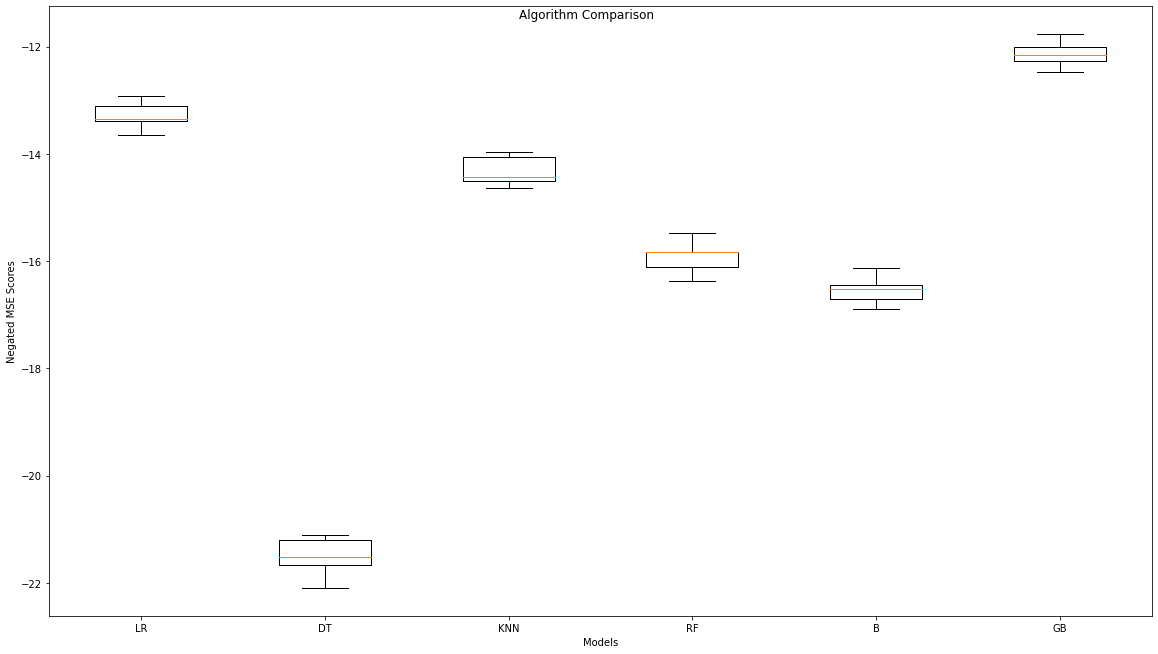

In [151]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_MSE_Except-AB.png', dpi=600)
plt.show()

In [152]:
if 'AB' in abs_mse_reg_scores.keys():
    del abs_mse_reg_scores['AB'] 
abs_mse_reg_scores

{'LR': array([13.34093733, 13.37960028, 13.09999017, 13.64737818, 12.91228524]),
 'DT': array([21.10857299, 21.52136634, 21.66655147, 22.09579899, 21.20135714]),
 'KNN': array([14.43557986, 14.50167767, 14.05376363, 14.62671421, 13.96920778]),
 'RF': array([15.82990007, 16.11282256, 15.83539262, 16.3756692 , 15.46661896]),
 'B': array([16.52021188, 16.70595537, 16.44222728, 16.88928428, 16.12487309]),
 'GB': array([12.16447602, 12.26489861, 12.00334732, 12.46672817, 11.76607881])}

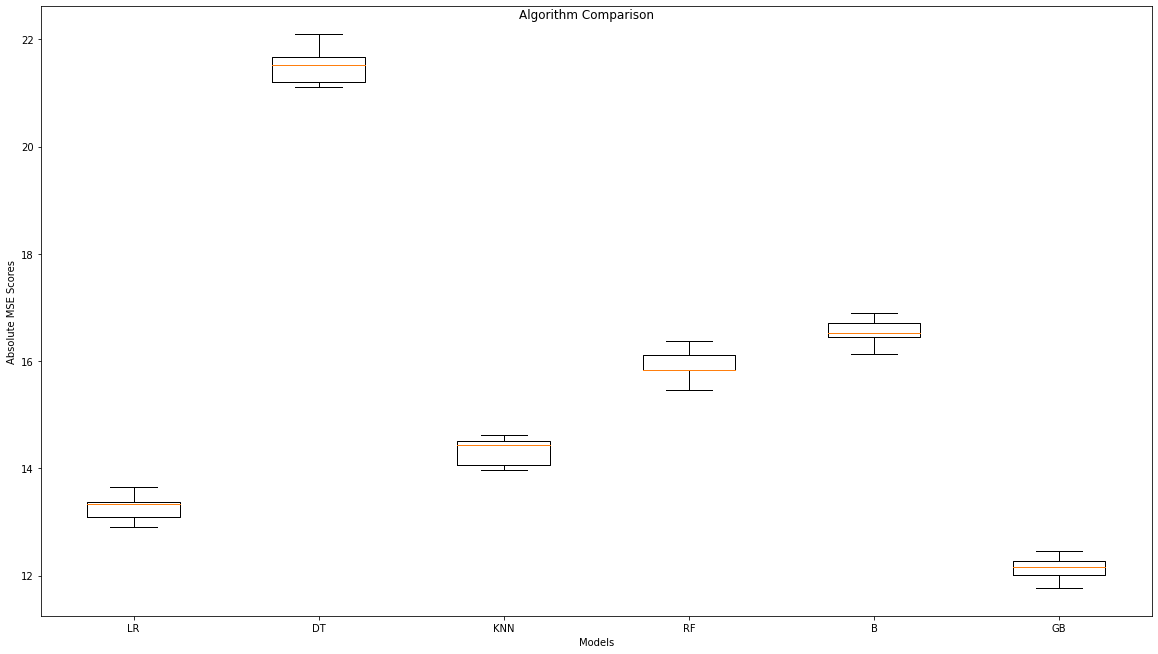

In [153]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_ABS-MSE_Except-AB.png', dpi=600)
plt.show()

In [154]:
r2_reg_scores = {}

In [155]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: 0.068958 (std: 0.012635, max: 0.085011, min: 0.055114) took 0.984306 seconds
DT: avg: -0.509540 (std: 0.010058, max: -0.494060, min: -0.525583) took 0.602019 seconds
KNN: avg: -0.004103 (std: 0.014677, max: 0.018394, min: -0.019015) took 0.586546 seconds
RF: avg: -0.114182 (std: 0.014700, max: -0.094523, min: -0.130595) took 0.616749 seconds
AB: avg: -0.583467 (std: 0.357772, max: -0.072606, min: -1.125808) took 1.095865 seconds
B: avg: -0.163985 (std: 0.011947, max: -0.144872, min: -0.180598) took 0.559708 seconds
GB: avg: 0.149086 (std: 0.011562, max: 0.164546, min: 0.136695) took 0.551905 seconds


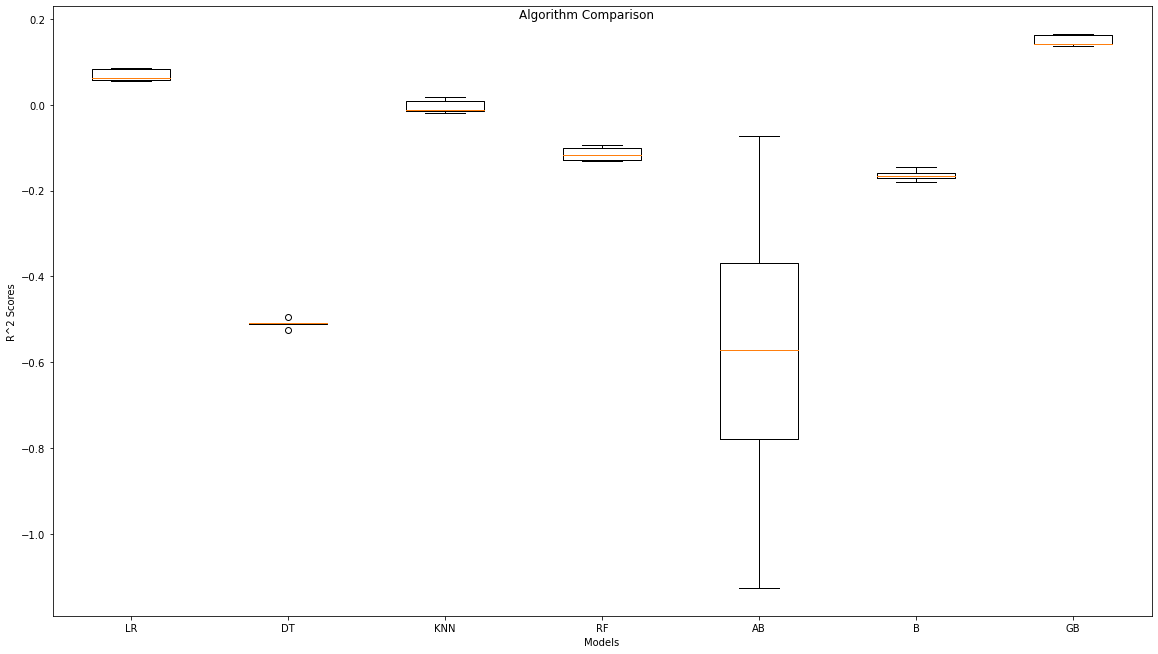

In [156]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/South-Holland-10prct_R2.png', dpi=600)
plt.show()

In [157]:
if 'AB' in r2_reg_scores.keys():
    del r2_reg_scores['AB']
r2_reg_scores

{'LR': array([0.05825653, 0.06324708, 0.08501138, 0.05511391, 0.0831593 ]),
 'DT': array([-0.49406016, -0.50947515, -0.51137742, -0.52558316, -0.50720228]),
 'KNN': array([-0.01901484, -0.01531351,  0.01839363, -0.01269113,  0.0081122 ]),
 'RF': array([-0.11718857, -0.12871639, -0.09988769, -0.13059487, -0.09452299]),
 'B': array([-0.16580882, -0.18059809, -0.15845507, -0.17018981, -0.14487206]),
 'GB': array([0.14131973, 0.14132203, 0.16154589, 0.13669503, 0.16454603])}

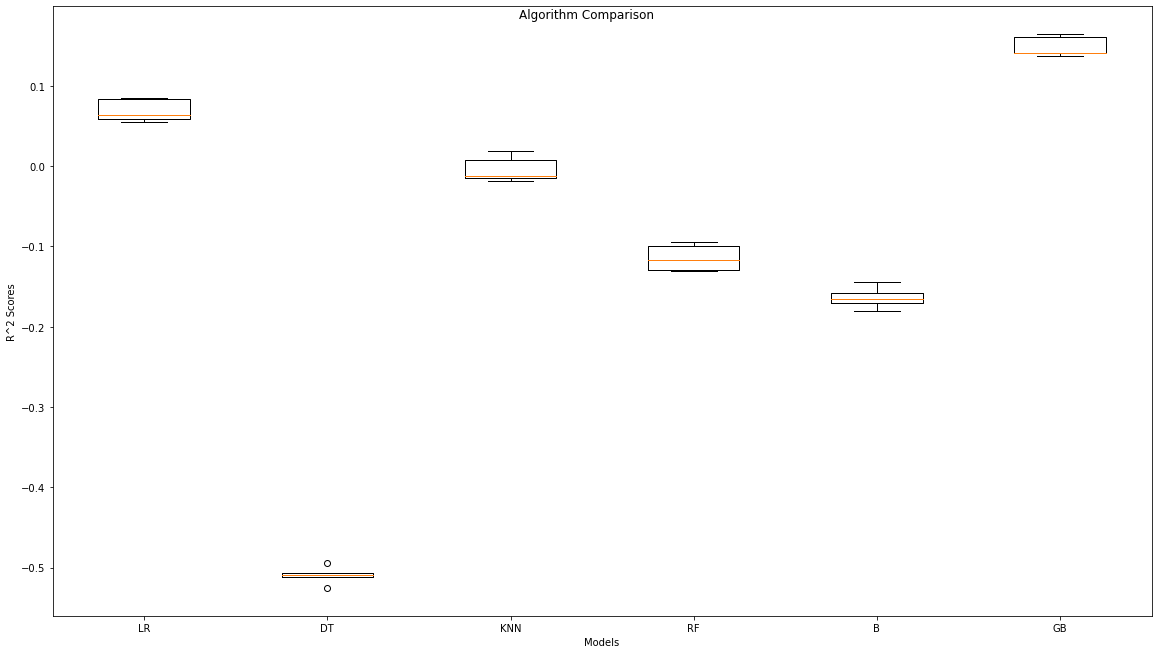

In [158]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run0/scaler/olland-10prct_R2_Except-AB.png', dpi=600)
plt.show()

In [103]:
regressors = []
regressors.append(('LR', LinearRegression()))
# regressors.append(('DT', DecisionTreeRegressor()))
regressors.append(('DT', DecisionTreeRegressor(max_depth=50, random_state=42)))
# regressors.append(('KNN', KNeighborsRegressor()))
regressors.append(('KNN', KNeighborsRegressor(n_neighbors=1500, weights="distance")))
# regressors.append(('RF', RandomForestRegressor()))
regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))
reg_scores = {}

In [104]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: -13.494050 (std: 0.980452, max: -12.687081, min: -15.374159)
DT: avg: -12.553752 (std: 1.045457, max: -11.558389, min: -14.449988)
KNN: avg: -12.524554 (std: 1.245730, max: -11.119445, min: -14.763945)
RF: avg: -12.363640 (std: 1.136406, max: -11.105269, min: -14.386154)
AB: avg: -13.956395 (std: 1.016735, max: -12.490656, min: -15.010798)
GB: avg: -12.336615 (std: 1.035473, max: -11.372554, min: -14.237003)


[]

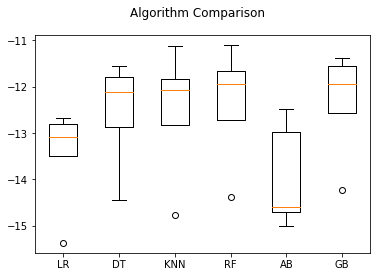

In [105]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(reg_scores.values())
ax.set_xticklabels(reg_scores.keys())
plt.plot()

In [115]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor())])

In [117]:
grid_params = {
    'preprocessor__year_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__bldg_lvls_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.3, train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('year_transformer',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator...
                                                         

In [118]:
best_params = grid_search.best_params_
best_params

{'preprocessor__bldg_lvls_transformer__imputer__strategy': 'most_frequent',
 'preprocessor__year_transformer__imputer__strategy': 'most_frequent',
 'regressor__max_depth': 10,
 'regressor__max_features': 'sqrt',
 'regressor__n_estimators': 100}

In [ ]:
best_estimator = grid_search.best_estimator_
print(best_estimator)


In [120]:
best_score = grid_search.best_score_
best_score

-12.279197621416357

In [121]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor())])

In [ ]:
grid_params = {
    'preprocessor__year_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__bldg_lvls_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'regressor__learning_rate': [0.05, 0.01, 0.1, 0.5],
    'regressor__criterion': ['friedman_mse', 'mse'],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

In [ ]:
y_pred = grid_search.predict(X_test)
y_pred_probs = grid_search.predict_proba(X_test)
display(y_pred)

In [ ]:
print(mean_squared_error(y_test, y_pred))